## 1. Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from dotenv import load_dotenv
import logging

load_dotenv()

# Add the parent directory of src to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

from tqdm import tqdm

from src.data.read_data import load_data
from src.visualization.helper_visualizations import analyze_target_distribution
from src.features.feature_encoder import LabelEncoderWrapper 


from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

%matplotlib inline

## 2. Data load

In [14]:
# Retrieve file paths from environment variables
churn_data_path = os.getenv('CHURN_DATASET')

# Load datasets into pandas DataFrames
churn_df = load_data(churn_data_path)

In [15]:
pd.set_option('display.max_columns', None)
churn_df.head()
#pd.reset_option('display.max_columns')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Exploratory data analysis and data quality assessment

In [16]:
for column in churn_df.drop(columns=['customerID', 'tenure', 'SeniorCitizen' ,'MonthlyCharges', 'TotalCharges']).columns:
    print(f"Number of unique categories for feature {column}: \n {churn_df[column].unique()}")

Number of unique categories for feature gender: 
 ['Female' 'Male']
Number of unique categories for feature Partner: 
 ['Yes' 'No']
Number of unique categories for feature Dependents: 
 ['No' 'Yes']
Number of unique categories for feature PhoneService: 
 ['No' 'Yes']
Number of unique categories for feature MultipleLines: 
 ['No phone service' 'No' 'Yes']
Number of unique categories for feature InternetService: 
 ['DSL' 'Fiber optic' 'No']
Number of unique categories for feature OnlineSecurity: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature OnlineBackup: 
 ['Yes' 'No' 'No internet service']
Number of unique categories for feature DeviceProtection: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature TechSupport: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature StreamingTV: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature StreamingMovies: 
 ['No' 'Yes' 'No internet service']
Numb

In [17]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [18]:
# Since TotalCharges is of type 'object' we will need to convert it to float

churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')

churn_df.isna().mean()

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

In [19]:
churn_df.dropna(subset=['TotalCharges'], inplace=True)

Percentage of each category in 'Churn':
No: 73.42%
Yes: 26.58%


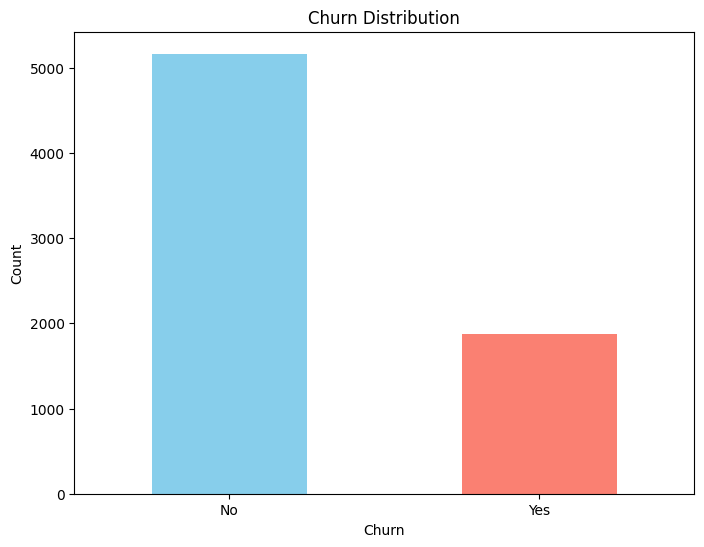

In [20]:
analyze_target_distribution(churn_df, 'Churn')

## 4. Machine Learning

In [21]:
encoder = LabelEncoderWrapper()
cols = churn_df.drop(columns=['customerID', 'tenure', 'SeniorCitizen' ,'MonthlyCharges', 'TotalCharges']).columns

  # Apply the fit_transform method
df_transformed = encoder.fit_transform(churn_df.copy(), cols)
print("Transformed DataFrame:")
df_transformed.head()

# Apply the inverse_transform method
#df_reversed = encoder.inverse_transform(df_transformed.copy())
#print("\nReversed DataFrame:")
#print(df_reversed)

Transformed DataFrame:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [22]:

# Split data into training and test sets
X = df_transformed.drop(columns= ['customerID','Churn'], axis=1)
y = df_transformed['Churn']

# Split the data into 60% training and 40% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split the temporary set into 50% validation and 50% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [23]:
# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print("\n")

# Check the class distribution in each split
print("Class distribution in training set:", y_train.value_counts(normalize=True))
print("Class distribution in validation set:", y_val.value_counts(normalize=True))
print("Class distribution in test set:", y_test.value_counts(normalize=True))

Training set size: 4219
Validation set size: 1406
Test set size: 1407


Class distribution in training set: Churn
0    0.734297
1    0.265703
Name: proportion, dtype: float64
Class distribution in validation set: Churn
0    0.733997
1    0.266003
Name: proportion, dtype: float64
Class distribution in test set: Churn
0    0.734186
1    0.265814
Name: proportion, dtype: float64


### 4.1 1st approach: Leaving the imbalanced dataset as is

In [24]:
# Define the models and hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(), 
    'LightGBM': lgb.LGBMClassifier()
}

In [25]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'scale_pos_weight': [1, sum(y == 0) / sum(y == 1)],
        'eval_metric': ['logloss', 'aucpr']
    },
    'LightGBM': {
        'n_estimators': [100, 200, 500],
        'num_leaves': [31, 61, 91],
        'learning_rate': [0.01, 0.1, 0.2],
        #'scale_pos_weight': [1, sum(y == 0) / sum(y == 1)],
        'is_unbalance': [True]
    }
}

In [26]:
# Perform cross-validation and hyperparameter tuning with progress bar
best_models = {}
for model_name in tqdm(models, desc='Training models'):
    print(f"\nTraining {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='f1', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} model: {grid_search.best_params_}")


Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Training RandomForest...


Training models:  33%|███▎      | 1/3 [02:50<05:41, 170.64s/it]

Best RandomForest model: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Training XGBoost...


Training models:  67%|██████▋   | 2/3 [03:18<01:26, 86.89s/it] 

Best XGBoost model: {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'scale_pos_weight': 2.7624398073836276}

Training LightGBM...
[LightGBM] [Info] Number of positive: 897, number of negative: 2478[LightGBM] [Info] Number of positive: 897, number of negative: 2479

[LightGBM] [Info] Number of positive: 896, number of negative: 2479[LightGBM] [Info] Number of positive: 897, number of negative: 2478
[LightGBM] [Info] Number of positive: 897, number of negative: 2478

[LightGBM] [Info] Number of positive: 897, number of negative: 2478
[LightGBM] [Info] Number of positive: 897, number of negative: 2478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005181 seconds.
You can set `force_row_wi

Training models: 100%|██████████| 3/3 [07:01<00:00, 140.60s/it]

Best LightGBM model: {'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}



Evaluating RandomForest on the test set...
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1033
           1       0.56      0.77      0.65       374

    accuracy                           0.78      1407
   macro avg       0.73      0.78      0.74      1407
weighted avg       0.81      0.78      0.79      1407



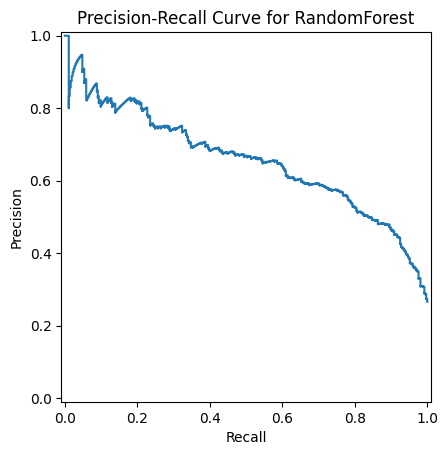


Evaluating XGBoost on the test set...
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407



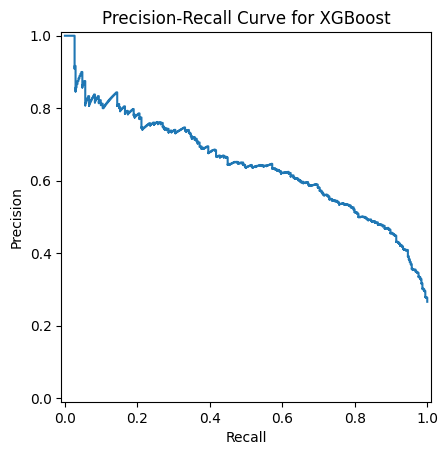


Evaluating LightGBM on the test set...
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



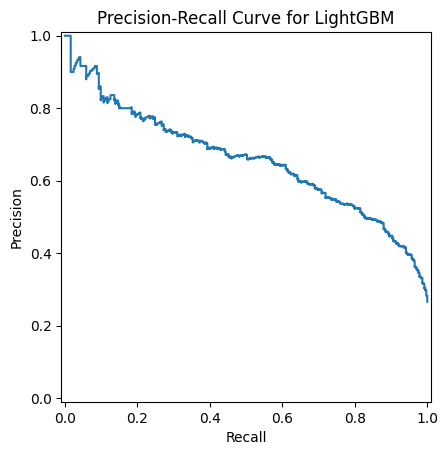

In [27]:
# Evaluate the models on the test set
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Plot the precision-recall curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

### 4.2 2nd approach: Oversampling

In [28]:
# Define the models and hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(verbose = -1)
}

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced'],
        'oversampler__sampling_strategy': [0.5, 1.0]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__scale_pos_weight': [1, sum(y == 0) / sum(y == 1)],
        'oversampler__sampling_strategy': [0.5, 1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__num_leaves': [31, 61, 91],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__is_unbalance': [True],
        'oversampler__sampling_strategy': [0.5, 1.0]
    }
}

In [29]:
# Perform cross-validation and hyperparameter tuning with progress bar
best_models = {}
for model_name in tqdm(models, desc='Training models'):
    print(f"\nTraining {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    pipeline = ImbPipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=5, scoring='f1', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} model: {grid_search.best_params_}")


Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Training RandomForest...


Training models:  33%|███▎      | 1/3 [06:04<12:08, 364.06s/it]

Best RandomForest model: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'oversampler__sampling_strategy': 1.0}

Training XGBoost...


Training models:  67%|██████▋   | 2/3 [06:27<02:43, 163.53s/it]

Best XGBoost model: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1, 'oversampler__sampling_strategy': 1.0}

Training LightGBM...


Training models: 100%|██████████| 3/3 [13:03<00:00, 261.18s/it]

Best LightGBM model: {'classifier__is_unbalance': True, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31, 'oversampler__sampling_strategy': 0.5}



Evaluating RandomForest on the test set...
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.54      0.77      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



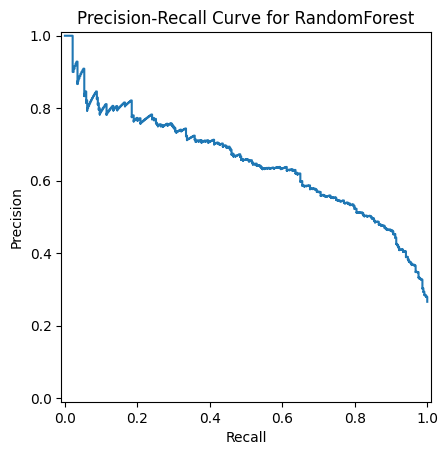


Evaluating XGBoost on the test set...
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1033
           1       0.51      0.82      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407



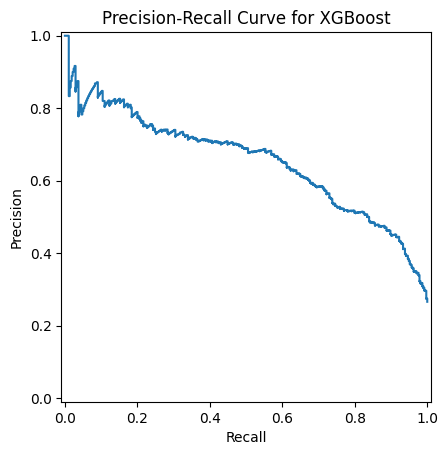


Evaluating LightGBM on the test set...
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1033
           1       0.54      0.78      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



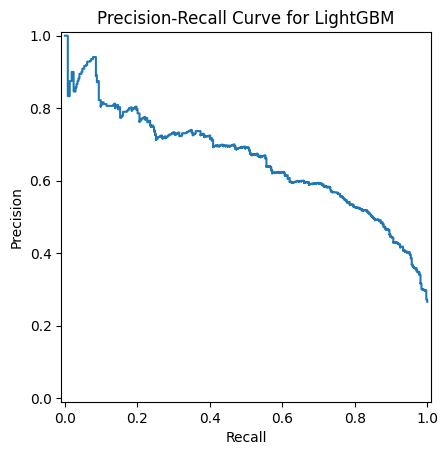

In [30]:
# Evaluate the models on the test set
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Plot the precision-recall curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

### 4.3 3rd approach: Undersampling

In [31]:
# Define the models and hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(verbose = -1)
}

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced'],
        'undersampler__sampling_strategy': [0.5, 1.0],
        'undersampler__replacement': [False, True]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__scale_pos_weight': [1, sum(y == 0) / sum(y == 1)],
        'undersampler__sampling_strategy': [0.5, 1.0],
        'undersampler__replacement': [False, True]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__num_leaves': [31, 61, 91],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__is_unbalance': [True],
        'undersampler__sampling_strategy': [0.5, 1.0],
        'undersampler__replacement': [False, True]
    }
}


In [32]:
# Perform cross-validation and hyperparameter tuning with progress bar
best_models = {}
for model_name in tqdm(models, desc='Training models'):
    print(f"\nTraining {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    pipeline = ImbPipeline([
        ('undersampler', RandomUnderSampler(random_state=42)),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=5, scoring='f1', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} model: {grid_search.best_params_}")

Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Training RandomForest...


Training models:  33%|███▎      | 1/3 [08:52<17:45, 532.62s/it]

Best RandomForest model: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'undersampler__replacement': True, 'undersampler__sampling_strategy': 0.5}

Training XGBoost...


Training models:  67%|██████▋   | 2/3 [09:40<04:07, 247.54s/it]

Best XGBoost model: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 500, 'classifier__scale_pos_weight': 1, 'undersampler__replacement': True, 'undersampler__sampling_strategy': 1.0}

Training LightGBM...


Training models: 100%|██████████| 3/3 [23:23<00:00, 467.78s/it]

Best LightGBM model: {'classifier__is_unbalance': True, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31, 'undersampler__replacement': False, 'undersampler__sampling_strategy': 0.5}



Evaluating RandomForest on the test set...
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1033
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



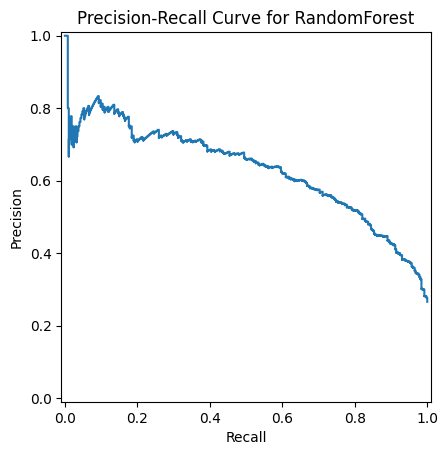


Evaluating XGBoost on the test set...
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1033
           1       0.49      0.83      0.62       374

    accuracy                           0.72      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.81      0.72      0.74      1407



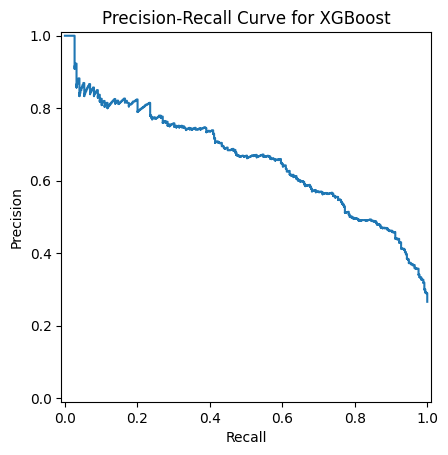


Evaluating LightGBM on the test set...
              precision    recall  f1-score   support

           0       0.90      0.74      0.82      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.77      1407



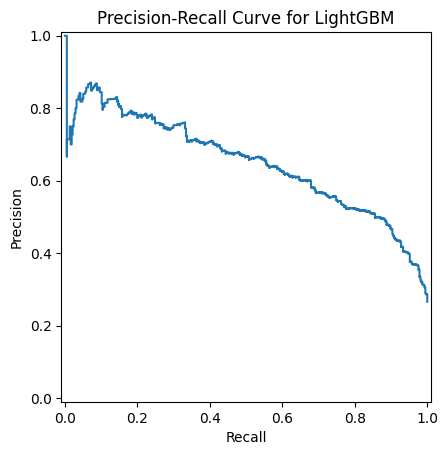

In [33]:
# Evaluate the models on the test set without undersampling
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Plot the precision-recall curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

### 4.4 SMOTE

In [34]:
# Define the models and hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(verbose=-1)
}

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced'],
        'smote__sampling_strategy': [0.5, 1.0],
        'smote__k_neighbors': [3, 5, 7]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__scale_pos_weight': [1, sum(y == 0) / sum(y == 1)],
        'smote__sampling_strategy': [0.5, 1.0],
        'smote__k_neighbors': [3, 5, 7]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__num_leaves': [31, 61, 91],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__is_unbalance': [True],
        'smote__sampling_strategy': [0.5, 1.0],
        'smote__k_neighbors': [3, 5, 7]
    }
}

In [35]:
# Perform cross-validation and hyperparameter tuning with progress bar
best_models = {}
for model_name in tqdm(models, desc='Training models'):
    print(f"\nTraining {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=5, scoring='f1', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} model: {grid_search.best_params_}")

Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Training RandomForest...


Training models:  33%|███▎      | 1/3 [23:27<46:54, 1407.24s/it]

Best RandomForest model: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500, 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.5}

Training XGBoost...


/Users/lucasmaretti/Documents/repos/imbalanced-data-study/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Training models:  67%|██████▋   | 2/3 [24:41<10:23, 623.08s/it] 

Best XGBoost model: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 500, 'classifier__scale_pos_weight': 2.7624398073836276, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.5}

Training LightGBM...


Training models: 100%|██████████| 3/3 [46:59<00:00, 939.89s/it]

Best LightGBM model: {'classifier__is_unbalance': True, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.5}



Evaluating RandomForest on the test set...
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1033
           1       0.56      0.71      0.63       374

    accuracy                           0.78      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.78      0.78      1407



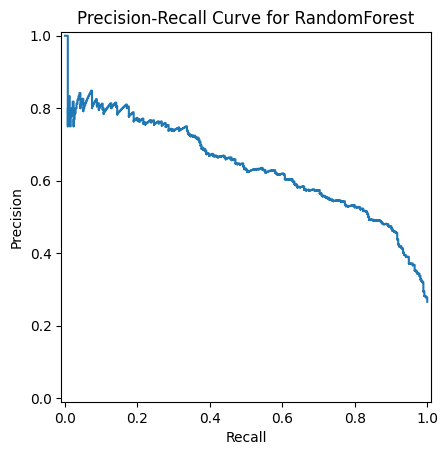


Evaluating XGBoost on the test set...
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1033
           1       0.50      0.83      0.63       374

    accuracy                           0.74      1407
   macro avg       0.71      0.77      0.71      1407
weighted avg       0.81      0.74      0.75      1407



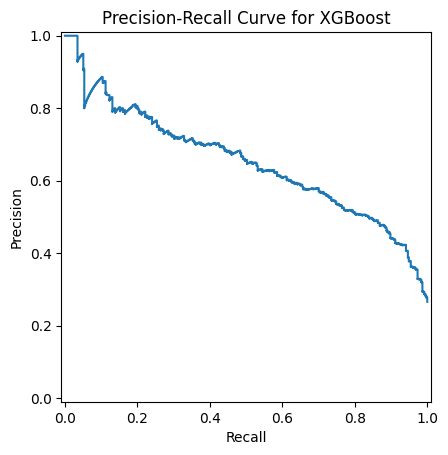


Evaluating LightGBM on the test set...
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1033
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



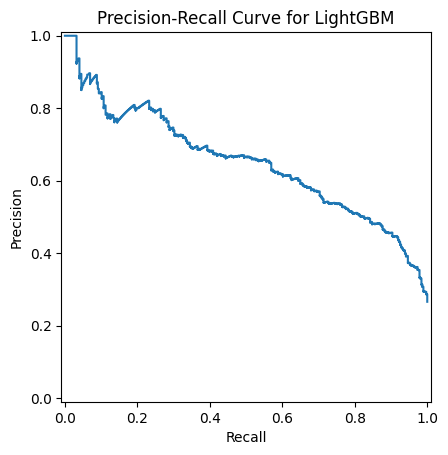

In [36]:
# Evaluate the models on the test set without SMOTE
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Plot the precision-recall curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

### 4.5 Final approach: doing nothing at all (no hyperparameter tuning)

In [37]:
# Define sampling techniques
oversample = RandomOverSampler()
undersample = RandomUnderSampler()
smote = SMOTE()

# Define a simple pipeline with RandomForestClassifier
model = RandomForestClassifier(random_state=42)

In [38]:
# Original data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Original Data Performance")
print(classification_report(y_test, y_pred))

Original Data Performance
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [39]:
# Oversampling
pipeline = Pipeline(steps=[('over', oversample), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Oversampling Performance")
print(classification_report(y_test, y_pred))

Oversampling Performance
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



In [40]:
# Undersampling
pipeline = Pipeline(steps=[('under', undersample), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Undersampling Performance")
print(classification_report(y_test, y_pred))

Undersampling Performance
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [41]:
# SMOTE
pipeline = Pipeline(steps=[('smote', smote), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("SMOTE Performance")
print(classification_report(y_test, y_pred))

SMOTE Performance
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1033
           1       0.58      0.61      0.60       374

    accuracy                           0.78      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.78      0.78      0.78      1407

